# Safety Classifier: A Simple CNN Model for Workplace Safety Compliance
### DIGIMAP - S13
```
Submitted by: Darius Vincent Ardales
```

# Introduction

Ensuring workplace safety is a critical aspect of construction site management. To address this, I have developed a Convolutional Neural Network (CNN) model designed to classify images as either **safe** or **unsafe**, based on the presence of essential Personal Protective Equipment (PPE) such as helmets and reflective vests. This model leverages digital image processing techniques, including affine transformations and color manipulation (saturation adjustment), for data augmentation to enhance the model's robustness and generalization.

The primary focus of this study is to minimize false negatives, where an unsafe image is misclassified as safe. As such, **recall** is chosen as the main evaluation metric to ensure the model effectively reduces the likelihood of incorrectly identifying an unsafe scenario as safe. Additionally, an in-depth analysis of the convolutional layers will be conducted post-training to better understand the features learned by the model.

# Dataset Overview

This dataset, sourced from Kaggle, is specifically designed for training and evaluating deep learning models aimed at classifying workplace safety compliance on construction sites. The dataset focuses on identifying whether an image meets the safety requirements based on the presence of PPE.

[Worksite Safety Monitoring Dataset](https://www.kaggle.com/datasets/lbquctrung/worksite-safety-monitoring-dataset/data)

## About the Dataset

- **Safe**: 1010 images  
- **Unsafe**: 1010 images  

The images were collected primarily from the internet and manually labeled by the research team to ensure accuracy and alignment with safety standards. Note that the dataset does not include bounding box annotations and is intended solely for image classification tasks.

## Safety Definition

An image is classified as **safe** if all individuals in the image are wearing:
1. A construction vest (typically orange or blue with reflective strips).
2. A safety helmet.

If even one person in the image lacks the required PPE, the image is classified as **unsafe**.

## Key Features

- **Binary Classification**: Safe vs. Unsafe
- Labeled for image classification without bounding boxes


# Importing Dependencies

In [340]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
from PIL import Image
from collections import Counter
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split


# For reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Checking the Data

### Initializing directories

In [207]:
base_dir = './data'
safe_dir = os.path.join(base_dir, 'safe')
unsafe_dir = os.path.join(base_dir, 'unsafe')

augmented_dir = './augmented'
augmented_safe_dir = os.path.join(augmented_dir, 'safe')
augmented_unsafe_dir = os.path.join(augmented_dir, 'unsafe')

# Create augmented directories if they do not exist
os.makedirs(augmented_safe_dir, exist_ok=True)
os.makedirs(augmented_unsafe_dir, exist_ok=True)

### Check for image size consistency in the dataset

In [208]:
def check_consistent_image_size(folder_path, name):
    """
    Checks if all images in the specified folder have consistent dimensions.

    Args:
        folder_path (str): Path to the folder containing images.
        name (str): Placeholder name.

    Returns:
        tuple: Dimensions (width, height) if all images have consistent size, or None if they do not.
    """
    n_files = sum([1 for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    print(f"Number of files in {name} : {n_files}")

    consistent_size = None
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
            file_path = os.path.join(folder_path, filename)
            try:
                with Image.open(file_path) as image:
                    width, height = image.size
                    if consistent_size is None:
                        consistent_size = (width, height)
                    elif consistent_size != (width, height):
                        print("Not all images have consistent dimensions.")
                        return None
            except Exception as e:
                print(f"Error opening image {filename}: {e}")

    if consistent_size:
        print(f"All images have consistent dimensions: {consistent_size[0]}x{consistent_size[1]}")
        return consistent_size
    else:
        print("No valid images found in the specified folder.")
        return None

In [209]:
check_consistent_image_size(safe_dir, "Safe Images")

Number of files in Safe Images : 1010
All images have consistent dimensions: 640x640


(640, 640)

In [210]:
check_consistent_image_size(unsafe_dir, "Unsafe Images")

Number of files in Unsafe Images : 1010
All images have consistent dimensions: 640x640


(640, 640)

In [211]:
sample_image_path = os.path.join(safe_dir, '1.jpg')
sample_image = cv.imread(sample_image_path)

### Display Image Functions

In [212]:
def display_images(image1, image2, title1="Before", title2="After"):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv.cvtColor(image1, cv.COLOR_BGR2RGB))
    plt.title(title1)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(cv.cvtColor(image2, cv.COLOR_BGR2RGB))
    plt.title(title2)
    plt.axis('off')
    plt.show()

In [213]:
def display_image(image_path, title="Image"):
    image = cv.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"No image found at the path: {image_path}")
    
    image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(image_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Loading the Data

### Initializing Transformation to Tensor

In [214]:
transform = transforms.Compose([
    transforms.Resize((640, 640)),  # Resize the image to 640x640
    transforms.ToTensor(), # Transform to tensor, normalized between 0-1
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normalized between -1 and 1
])

### Using ImageFolder to Load the Dataset

In [215]:
dataset = torchvision.datasets.ImageFolder(root=base_dir, transform=transform)

print("Classes:", dataset.classes)
print("Class-to-Index Mapping:", dataset.class_to_idx)

Classes: ['safe', 'unsafe']
Class-to-Index Mapping: {'safe': 0, 'unsafe': 1}


### Train test split (80% train, 20% test)

In [216]:
train_size = int(0.8 * len(dataset))  
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print(type(train_dataset))
print(type(test_dataset))

<class 'torch.utils.data.dataset.Subset'>
<class 'torch.utils.data.dataset.Subset'>


In [217]:
print(f"Train Size: {len(train_dataset)}")
print(f"Test Size: {len(test_dataset)}")

Train Size: 1616
Test Size: 404


# Data Augmentation

### Randomly putting a black patch over a portion of an image

In [218]:
# Function to randomly place a black patch over a portion of the image
def random_black_patch(image, patch_size=(64, 64)):
    image_copy = image.copy()
    rows, cols, _ = image_copy.shape
    
    x = np.random.randint(0, cols - patch_size[1])
    y = np.random.randint(0, rows - patch_size[0])

    # Setting the value to 0 makes it black
    image_copy[y:y + patch_size[0], x:x + patch_size[1]] = 0  
    return image_copy

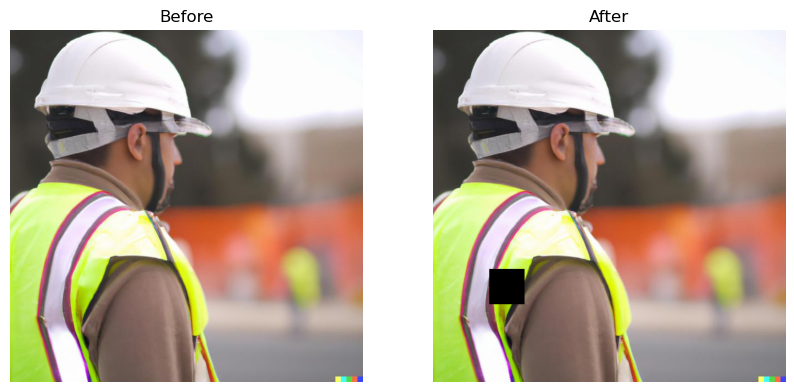

In [219]:
display_images(sample_image, random_black_patch(sample_image))

### Shifting an image sideward or upwards

In [220]:
# Function to shift an image either sideward or upward
def shift_image(image, x=64, y=64):
    image_copy = image.copy()
    rows, cols, ch = image_copy.shape
    
    M = np.float32([[1, 0, x], [0, 1, y]])
    shifted_image = cv.warpAffine(image_copy, M, (cols, rows))
    return shifted_image

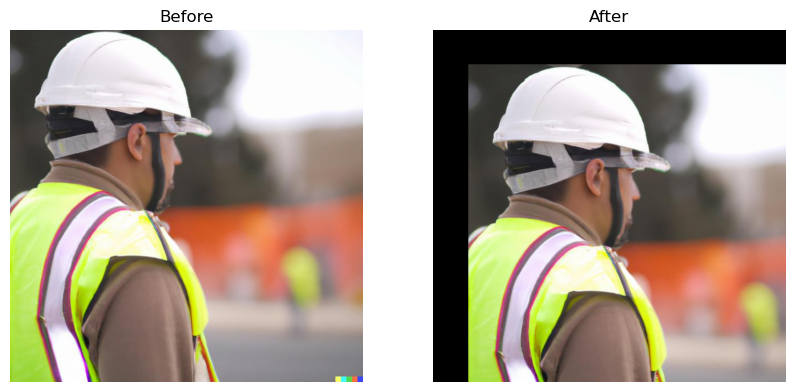

In [221]:
display_images(sample_image, shift_image(sample_image))

### Rotating an image

In [222]:
def rotate_image(image, theta=30, scale=1.0, center=None):
    image_copy = image.copy()
    rows, cols, ch = image_copy.shape
    
    # If no center is provided, use the geometric center of the image
    if center is None:
        center = ((cols - 1) / 2.0, (rows - 1) / 2.0)
    
    M = cv.getRotationMatrix2D(center, theta, scale)
    rotated_image = cv.warpAffine(image_copy, M, (cols, rows))
    
    return rotated_image

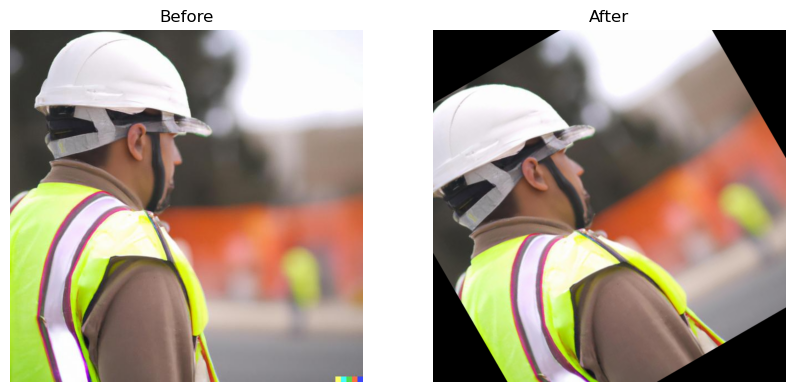

In [223]:
display_images(sample_image, rotate_image(sample_image))

### Flipping an image either vertically or horizontally

In [224]:
# Function to flip an image vertically or horizontally
def flip_image(image, flip_code=1):
    image_copy = image.copy()
    
    # flip_code: 1 = horizontal, 0 = vertical, -1 = both
    flipped_image = cv.flip(image_copy, flip_code)
    return flipped_image

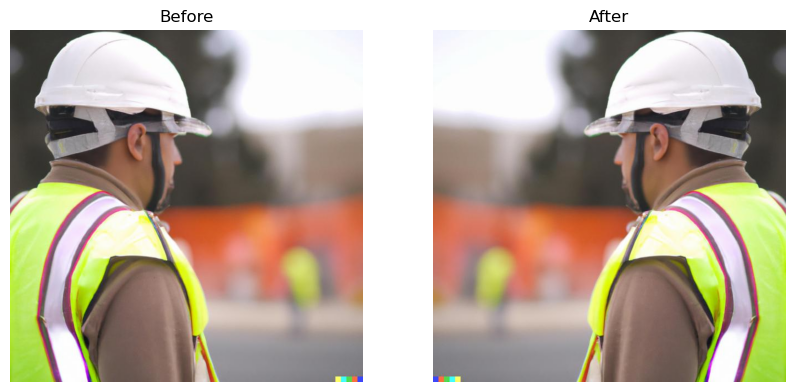

In [225]:
display_images(sample_image, flip_image(sample_image))

### Increase or decrease the saturation

In [226]:
# Function to adjust the saturation of an RGB image
def adjust_saturation(image, scale=1.5):
    hsv_image = cv.cvtColor(image, cv.COLOR_RGB2HSV)
    h, s, v = cv.split(hsv_image)
    
    s = np.clip(s * scale, 0, 255).astype(np.uint8)
    
    # Merge the channels back and convert to RGB
    adjusted_hsv = cv.merge([h, s, v])
    adjusted_rgb = cv.cvtColor(adjusted_hsv, cv.COLOR_HSV2RGB)
    
    return adjusted_rgb

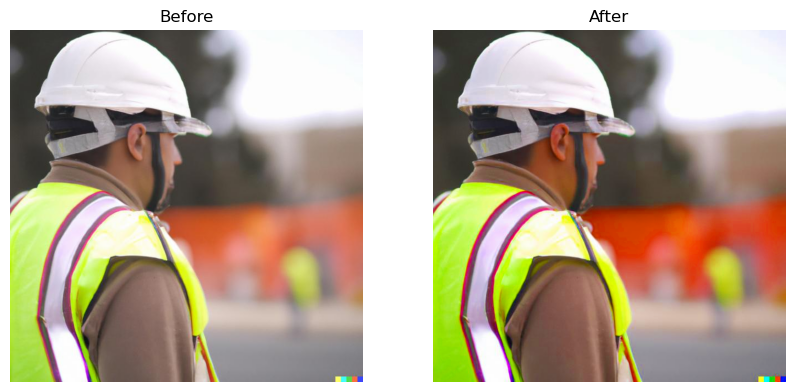

In [227]:
display_images(sample_image, adjust_saturation(sample_image))

### Apply the Augmentations

In [228]:
# Apply augmentation functions to each image in the training dataset and save to folders
def apply_augmentations_and_save(train_dataset, augmented_safe_dir, augmented_unsafe_dir):
    augmentation_funcs = [random_black_patch, shift_image, rotate_image, flip_image, adjust_saturation]
    
    for idx, (image, label) in enumerate(tqdm(train_dataset, desc="Applying Augmentations and Saving")):
        # Denormalize image before converting to uint8 and saving
        image_np = image.permute(1, 2, 0).cpu().numpy()  # Convert tensor to NumPy without scaling
        image_np = (image_np * 0.5 + 0.5) * 255  # Undo normalization and rescale to [0, 255]
        image_np = np.clip(image_np, 0, 255).astype(np.uint8)  # Clip to valid range and convert to uint8
        image_np = cv.cvtColor(image_np, cv.COLOR_RGB2BGR)  # Convert from RGB to BGR for OpenCV

        # Define the base directory based on the label
        base_dir = augmented_safe_dir if label == 0 else augmented_unsafe_dir
        base_name = f"train_image_{idx}"
        
        # Save the original image
        original_image_path = os.path.join(base_dir, f"{base_name}.jpg")
        cv.imwrite(original_image_path, image_np)
        
        # Apply each augmentation function once to create 5 new versions
        for i, func in enumerate(augmentation_funcs):
            augmented_image = image_np.copy()
            if func == random_black_patch:
                augmented_image = func(augmented_image, patch_size=(np.random.randint(32, 128), np.random.randint(32, 128)))
            elif func == shift_image:
                augmented_image = func(augmented_image, x=np.random.randint(-64, 64), y=np.random.randint(-64, 64))
            elif func == rotate_image:
                augmented_image = func(augmented_image, theta=np.random.randint(-45, 45), scale=np.random.uniform(0.8, 1.2))
            elif func == flip_image:
                augmented_image = func(augmented_image, flip_code=np.random.choice([0, 1, -1]))
            elif func == adjust_saturation:
                augmented_image = func(augmented_image, scale=np.random.uniform(0.5, 1.5))
            
            # Save augmented image
            augmented_image_name = f"{base_name}_aug_{i}.jpg"
            augmented_image_path = os.path.join(base_dir, augmented_image_name)
            cv.imwrite(augmented_image_path, augmented_image)

In [229]:
# Apply augmentations only to training dataset
apply_augmentations_and_save(train_dataset, augmented_safe_dir, augmented_unsafe_dir)

Applying Augmentations and Saving: 100%|██████████| 1616/1616 [01:55<00:00, 13.94it/s]


In [230]:
# Load the augmented training dataset from disk
dataset_augmented = torchvision.datasets.ImageFolder(root=augmented_dir, transform=transform)
train_dataset_augmented, _ = random_split(dataset_augmented, [len(dataset_augmented), 0])

In [231]:
print(f"Train Size: {len(train_dataset_augmented)}")
print(f"Test Size: {len(test_dataset)}")

Train Size: 9696
Test Size: 404


### Creating DataLoaders

In [232]:
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset_augmented, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Printing one batch

In [233]:
for images, labels in train_loader:
    print(labels)
    print("Batch of images shape:", images.shape)
    print("Batch of labels shape:", labels.shape)
    break

tensor([0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
        0, 1, 1, 1, 0, 0, 1, 1])
Batch of images shape: torch.Size([32, 3, 640, 640])
Batch of labels shape: torch.Size([32])


# Creating the Model

### Simple CNN Model

In [234]:
class SafetyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(157 * 157 * 24, 64)
        self.fc2 = nn.Linear(64, 1)
        
    def forward(self, x):
        # Input (3, 640, 640) image
        x = self.pool(F.relu(self.conv1(x)))
        # Convolution 1: (12, 636, 636)
        # Max Pooling: (12, 318, 318)
        x = self.pool(F.relu(self.conv2(x)))
        # Convolution 2: (24 , 314, 314)
        # Max Pooling: (24, 157, 157)
        x = torch.flatten(x, 1)
        # Flattened Size: 157 × 157 × 24 = 591,576
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        # Linear: 64
        x = self.fc2(x)
        # Linear: 1

        return x

In [235]:
safety_model = SafetyCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(safety_model.parameters(), lr=0.001, weight_decay=1e-4)

### Training the Model

In [236]:
def train(model, train_loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        print(f"Training epoch {epoch + 1}...")

        running_loss = 0.0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}")

        for i, data in progress_bar:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device).float()  # Ensure labels are float

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs).squeeze(1)  # Ensure outputs have shape [batch_size]

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass and updating weights
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix({"Loss": f"{running_loss / (i + 1):.4f}"})
    
        print(f"Epoch {epoch + 1} Completed. Average Loss: {running_loss / len(train_loader):.4f}")

In [237]:
train(safety_model, train_loader, criterion, optimizer, num_epochs=10)

Training epoch 1...


Epoch 1: 100%|██████████| 303/303 [04:29<00:00,  1.12it/s, Loss=0.7185]


Epoch 1 Completed. Average Loss: 0.7185
Training epoch 2...


Epoch 2: 100%|██████████| 303/303 [03:26<00:00,  1.47it/s, Loss=0.6766]


Epoch 2 Completed. Average Loss: 0.6766
Training epoch 3...


Epoch 3: 100%|██████████| 303/303 [03:27<00:00,  1.46it/s, Loss=0.5408]


Epoch 3 Completed. Average Loss: 0.5408
Training epoch 4...


Epoch 4: 100%|██████████| 303/303 [03:27<00:00,  1.46it/s, Loss=0.3035]


Epoch 4 Completed. Average Loss: 0.3035
Training epoch 5...


Epoch 5: 100%|██████████| 303/303 [03:29<00:00,  1.45it/s, Loss=0.2021]


Epoch 5 Completed. Average Loss: 0.2021
Training epoch 6...


Epoch 6: 100%|██████████| 303/303 [03:28<00:00,  1.46it/s, Loss=0.1658]


Epoch 6 Completed. Average Loss: 0.1658
Training epoch 7...


Epoch 7: 100%|██████████| 303/303 [03:28<00:00,  1.45it/s, Loss=0.1374]


Epoch 7 Completed. Average Loss: 0.1374
Training epoch 8...


Epoch 8: 100%|██████████| 303/303 [03:28<00:00,  1.45it/s, Loss=0.1262]


Epoch 8 Completed. Average Loss: 0.1262
Training epoch 9...


Epoch 9: 100%|██████████| 303/303 [03:28<00:00,  1.45it/s, Loss=0.1065]


Epoch 9 Completed. Average Loss: 0.1065
Training epoch 10...


Epoch 10: 100%|██████████| 303/303 [03:27<00:00,  1.46it/s, Loss=0.1091]

Epoch 10 Completed. Average Loss: 0.1091


# Saving the Model

In [238]:
torch.save(safety_model.state_dict(), "safety_model.pth")
print("Model saved to safety_model.pth")

Model saved to safety_model.pth


In [239]:
state_dict = torch.load("safety_model.pth")

for param_tensor in state_dict:
    print(f"Layer: {param_tensor} | Shape: {state_dict[param_tensor].size()}")

Layer: conv1.weight | Shape: torch.Size([12, 3, 5, 5])
Layer: conv1.bias | Shape: torch.Size([12])
Layer: conv2.weight | Shape: torch.Size([24, 12, 5, 5])
Layer: conv2.bias | Shape: torch.Size([24])
Layer: fc1.weight | Shape: torch.Size([64, 591576])
Layer: fc1.bias | Shape: torch.Size([64])
Layer: fc2.weight | Shape: torch.Size([1, 64])
Layer: fc2.bias | Shape: torch.Size([1])


# Model Evaluation (Test-Time Augmentation)

In [257]:
# Load the model for evaluation
safety_model.load_state_dict(torch.load("safety_model.pth"))
safety_model.eval()  # Set the model to evaluation mode

print("Model loaded from safety_model.pth")
print(safety_model)

Model loaded from safety_model.pth
SafetyCNN(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=591576, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


In [258]:
total_params = sum(p.numel() for p in safety_model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 37869129


In [259]:
tta_transforms = [
    transforms.Compose([]),
    transforms.Compose([transforms.RandomHorizontalFlip(p=1.0)]),
    transforms.Compose([transforms.RandomRotation(degrees=30)]), 
    transforms.Compose([transforms.RandomResizedCrop(size=(640, 640), scale=(0.8, 1.0))])
]

In [260]:
def test_with_tta(model, test_loader, criterion, tta_transforms, num_tta=5):
    model.eval()  
    test_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in tqdm(test_loader, desc="Testing with TTA"):
            images, labels = data
            labels = labels.to(device).float()

            # Accumulate outputs from multiple TTA augmentations
            augmented_predictions = torch.zeros(labels.shape[0], num_tta).to(device)
            for i in range(num_tta):
                # Apply each TTA transformation to the batch of images
                tta_transform = tta_transforms[i % len(tta_transforms)]
                augmented_images = torch.stack([tta_transform(image) for image in images])
                augmented_images = augmented_images.to(device)

                outputs = model(augmented_images).squeeze(1)  # Ensure outputs have shape [batch_size]

                # Store predictions for averaging
                augmented_predictions[:, i] = torch.sigmoid(outputs)

            # Average predictions over all TTA versions
            mean_predictions = torch.mean(augmented_predictions, dim=1)
            predicted_labels = (mean_predictions > 0.5).float()  # Threshold at 0.5 for binary classification

            # Store predictions and true labels for metrics calculation
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted_labels.cpu().numpy())

            # Calculate batch loss
            loss = criterion(mean_predictions, labels)
            test_loss += loss.item()

    # Calculate metrics
    average_test_loss = test_loss / len(test_loader)
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    # Calculate confusion matrix and metrics
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, zero_division=0)
    recall = recall_score(all_labels, all_predictions, zero_division=0)
    f1 = f1_score(all_labels, all_predictions, zero_division=0)

    # Print comprehensive results
    print(f"Test Loss: {average_test_loss:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")


In [256]:
print("--- Train Data ---")
test_with_tta(safety_model, train_loader, criterion, tta_transforms, num_tta=4)

--- Train Data ---


Testing with TTA: 100%|██████████| 303/303 [09:47<00:00,  1.94s/it]

Test Loss: 0.6226
Confusion Matrix:
[[4195  683]
 [ 311 4507]]
Accuracy: 0.8975
Precision: 0.8684
Recall: 0.9355
F1 Score: 0.9007


In [255]:
print("\n--- Test Data ---")
test_with_tta(safety_model, test_loader, criterion, tta_transforms, num_tta=4)


--- Test Data ---


Testing with TTA: 100%|██████████| 13/13 [00:23<00:00,  1.81s/it]

Test Loss: 0.6756
Confusion Matrix:
[[121  76]
 [ 57 150]]
Accuracy: 0.6708
Precision: 0.6637
Recall: 0.7246
F1 Score: 0.6928


The SafetyCNN model demonstrated strong performance on the training data with an accuracy of **89.75%** and a high recall of **93.55%**, indicating its effectiveness in identifying safety compliance. However, performance on the test data was moderate, with an accuracy of **67.08%** and recall of **72.46%**, suggesting the model may struggle with generalization to unseen data. The high recall across both datasets highlights the model's reliability in minimizing false negatives, which is critical for ensuring safety compliance detection. Future improvements could focus on enhancing precision and addressing overfitting or dataset imbalances.

# Classifying Sample Images

In [336]:
def classify_image_with_tta(image_path, model, tta_transforms, num_tta=4):
    # Load the image
    image = Image.open(image_path)
    
    # List to accumulate predictions from TTA versions
    augmented_predictions = []

    # Apply each TTA transformation to the image
    for i in range(num_tta):
        tta_transform = tta_transforms[i % len(tta_transforms)]
        augmented_image = tta_transform(image)
        
        # Preprocess the image for the model
        transform = transforms.Compose([
            transforms.Resize((640, 640)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        input_tensor = transform(augmented_image).unsqueeze(0)  # Add batch dimension (1, 3, 640, 640)
        input_tensor = input_tensor.to(device)

        # Run the model on the augmented image
        with torch.no_grad():
            output = model(input_tensor).squeeze(1)

        # Apply sigmoid to get the probability
        prob = torch.sigmoid(output).item()
        augmented_predictions.append(prob)

    # Average predictions over all TTA versions
    avg_prob = np.mean(augmented_predictions)

    # Set a threshold of 0.5 for binary classification
    prediction = 1 if avg_prob > 0.5 else 0

    display_image(image_path, f"Prediction : {'Unsafe' if prediction == 1 else 'Safe'}\nSigmoid Output: {avg_prob:.4f}")
        
    return prediction

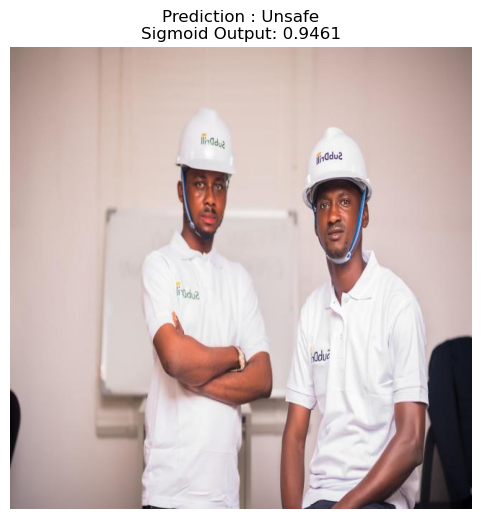

In [339]:
image_path = os.path.join(unsafe_dir, '14.jpg')

prediction = classify_image_with_tta(image_path, safety_model, tta_transforms, num_tta=4)


# Convolutional Layer Analysis

In [306]:
print(safety_model.conv1.weight.data.cpu().numpy().shape)
print(safety_model.conv2.weight.data.cpu().numpy().shape)

(12, 3, 5, 5)
(24, 12, 5, 5)


### Visualizing Convolutional Layers

In [334]:
def visualize_conv_layers(model, image_path, transform):
    import matplotlib.pyplot as plt
    from PIL import Image
    import torch
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load and transform the image
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension (1, 3, 640, 640)
    image = image.to(device)

    # Get the layers of the model
    layers = [model.conv1, model.pool, model.conv2, model.pool]

    # Pass the image through each layer and visualize the output
    x = image
    for i, layer in enumerate(layers):
        x = layer(x)  # Forward pass through the layer
        if isinstance(layer, torch.nn.Conv2d):
            # Visualize the feature maps outputted by the convolutional layer
            num_filters = x.shape[1]
            num_cols = 4
            num_rows = (num_filters + num_cols - 1) // num_cols
            fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
            fig.suptitle(f'Output of Layer {i+1} ({layer})', fontsize=16)

            for idx in range(num_filters):
                row, col = divmod(idx, num_cols)
                ax = axes[row, col] if num_rows > 1 else axes[col]
                feature_map = x[0, idx].cpu().detach().numpy()  # Extract the feature map
                ax.imshow(feature_map, cmap='viridis')
                ax.axis('off')
                ax.set_title(f'Filter {idx}', fontsize=10)  # Add filter number

            # Hide any unused subplots
            for idx in range(num_filters, num_rows * num_cols):
                row, col = divmod(idx, num_cols)
                ax = axes[row, col] if num_rows > 1 else axes[col]
                ax.axis('off')

            plt.show()

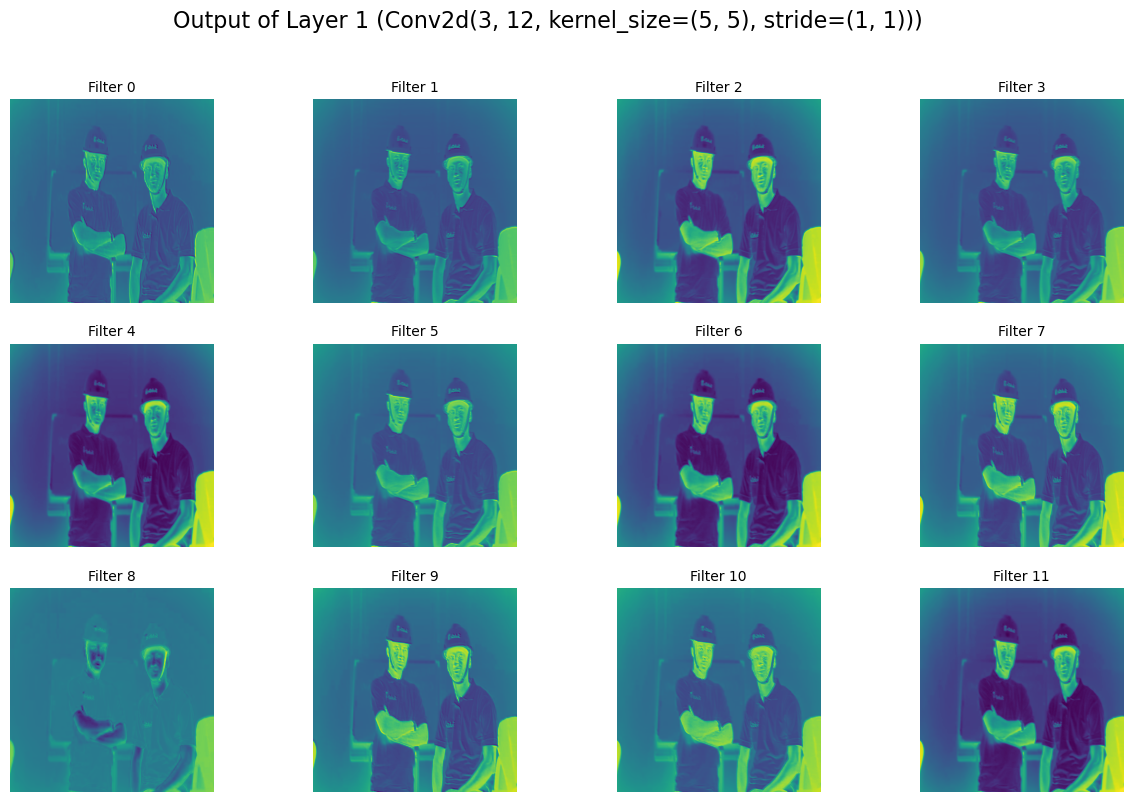

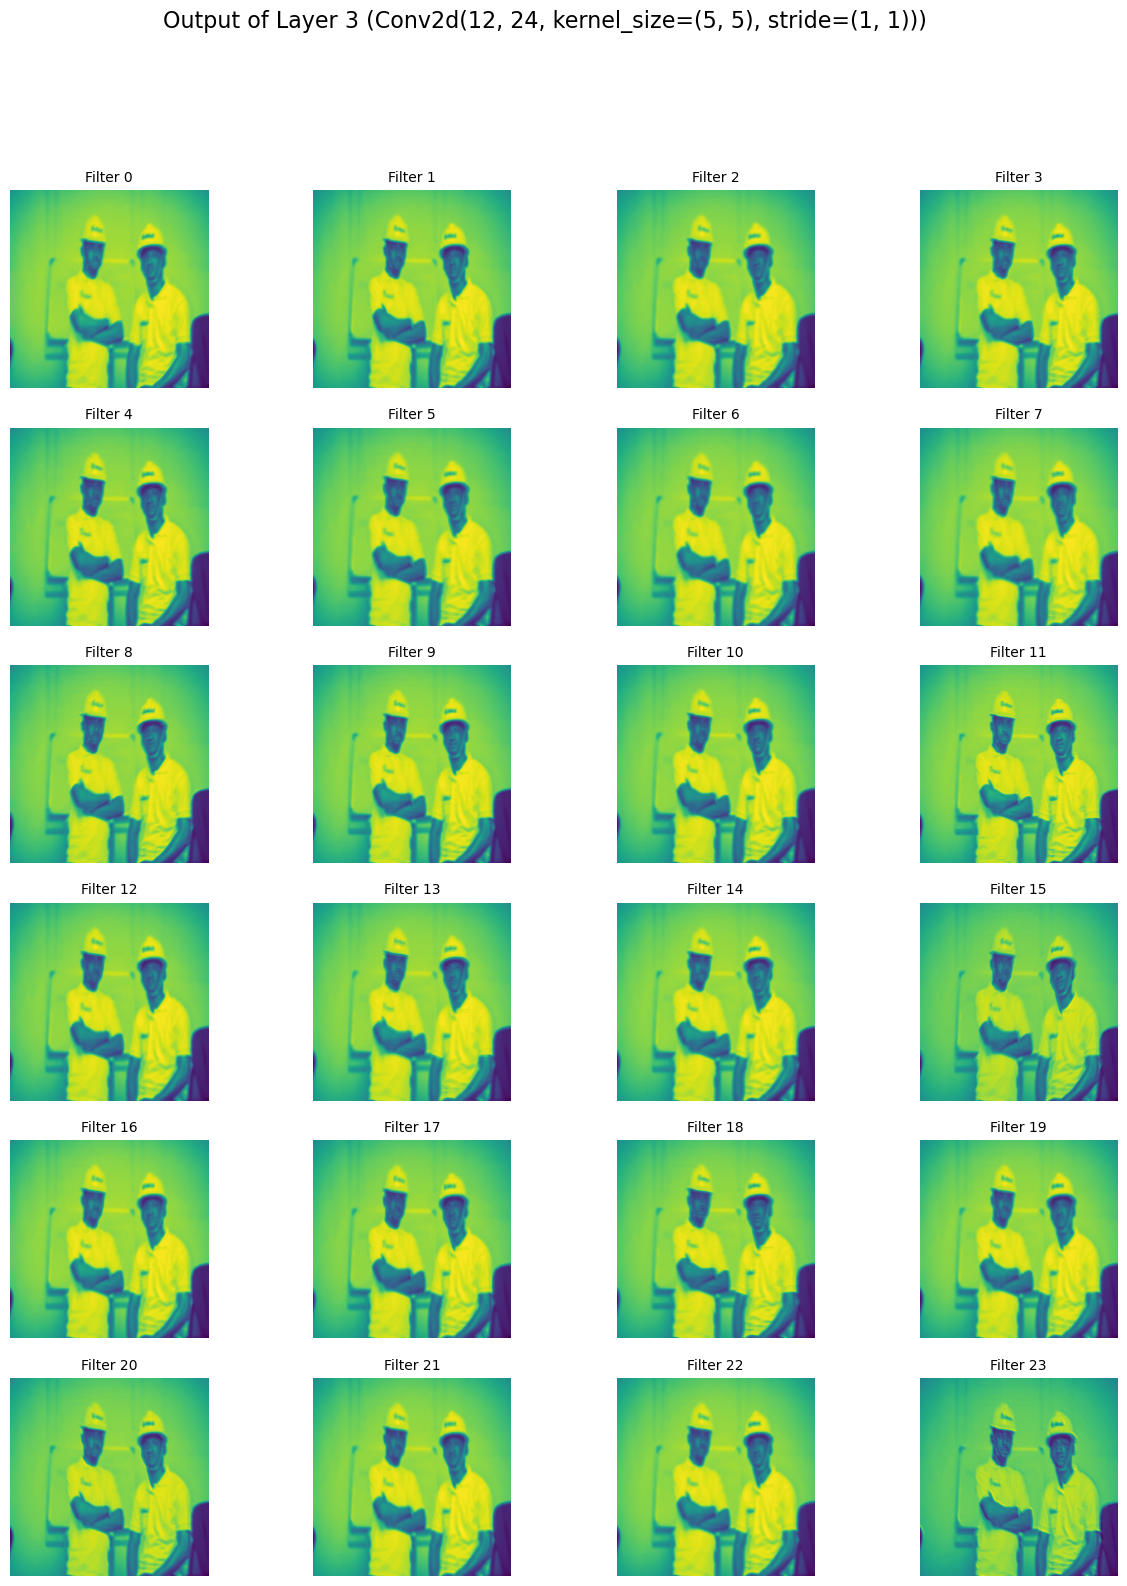

In [335]:
visualize_conv_layers(safety_model, image_path, transform)

### Check the Kernel Weights for all Channels

In [288]:
def print_conv_layer_parameters(model):
    # Print learned parameters (weights) of each convolutional layer
    conv_layers = [model.conv1, model.conv2]

    for i, layer in enumerate(conv_layers):
        weights = layer.weight.data.cpu().numpy()  # Get the weight tensor and convert to numpy
        print(f'Convolutional Layer {i+1} Weights:')
        for out_channel in range(weights.shape[0]):
            for in_channel in range(weights.shape[1]):
                print(f'Filter {out_channel}, Input Channel {in_channel}:')
                print(weights[out_channel, in_channel])
                print('-' * 50)

In [289]:
print_conv_layer_parameters(safety_model)

Convolutional Layer 1 Weights:
Filter 0, Input Channel 0:
[[-0.06160134 -0.01055082 -0.00334106 -0.04087581  0.00410807]
 [-0.07250625  0.10173952 -0.10891297 -0.1064323  -0.1300205 ]
 [ 0.09612182 -0.04669527 -0.06062983  0.02191248 -0.05090278]
 [ 0.11697758  0.04222477 -0.02458572 -0.10928535 -0.14596252]
 [ 0.05614435  0.02687379  0.10250922 -0.12284826  0.00208046]]
--------------------------------------------------
Filter 0, Input Channel 1:
[[ 0.07676197  0.08684488  0.05577543 -0.01253247 -0.10938566]
 [ 0.01846424  0.14487115 -0.08754864 -0.09096457  0.09360923]
 [ 0.04270088 -0.00058496  0.01930308  0.03717687 -0.00321867]
 [ 0.14472863  0.03643094 -0.03247838 -0.05782092 -0.01974675]
 [ 0.03691938  0.12945995  0.08257366  0.10116126  0.09629516]]
--------------------------------------------------
Filter 0, Input Channel 2:
[[ 0.07152744 -0.1446163  -0.09015444 -0.0712209   0.03128692]
 [-0.01757991  0.01416603 -0.07970577 -0.18723375 -0.0576167 ]
 [-0.00799385 -0.09121639  0

### Convolutional Layer 1 Heatmaps

In [328]:
def plot_conv1_layer_heatmaps(model):
    # Extract the convolutional layers
    conv_layers = [model.conv1]
    
    for i, layer in enumerate(conv_layers):
        weights = layer.weight.data.cpu().numpy()  # Get the weight tensor and convert to numpy
        num_filters, num_input_channels, _, _ = weights.shape  # Get the shape of the weights

        fig, axes = plt.subplots(
            num_filters, num_input_channels,
            figsize=(15, num_filters * 4),
            constrained_layout=True
        )
        
        for out_channel in range(num_filters):
            for in_channel in range(num_input_channels):
                heatmap_data = weights[out_channel, in_channel]
                ax = axes[out_channel, in_channel] if num_filters > 1 else axes[in_channel]
                im = ax.imshow(heatmap_data, cmap='viridis')
                ax.set_title(f"Filter {out_channel}, Input Channel {in_channel}", fontsize=8)
                
                # Annotate the heatmap with the numerical values
                for x in range(heatmap_data.shape[0]):
                    for y in range(heatmap_data.shape[1]):
                        ax.text(y, x, f"{heatmap_data[x, y]:.4f}", ha="center", va="center", fontsize=12, color="white")
                
                ax.axis('off')
                fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        plt.suptitle(f"Heatmaps with Values for Convolutional Layer {i+1}", fontsize=16)
        plt.show()

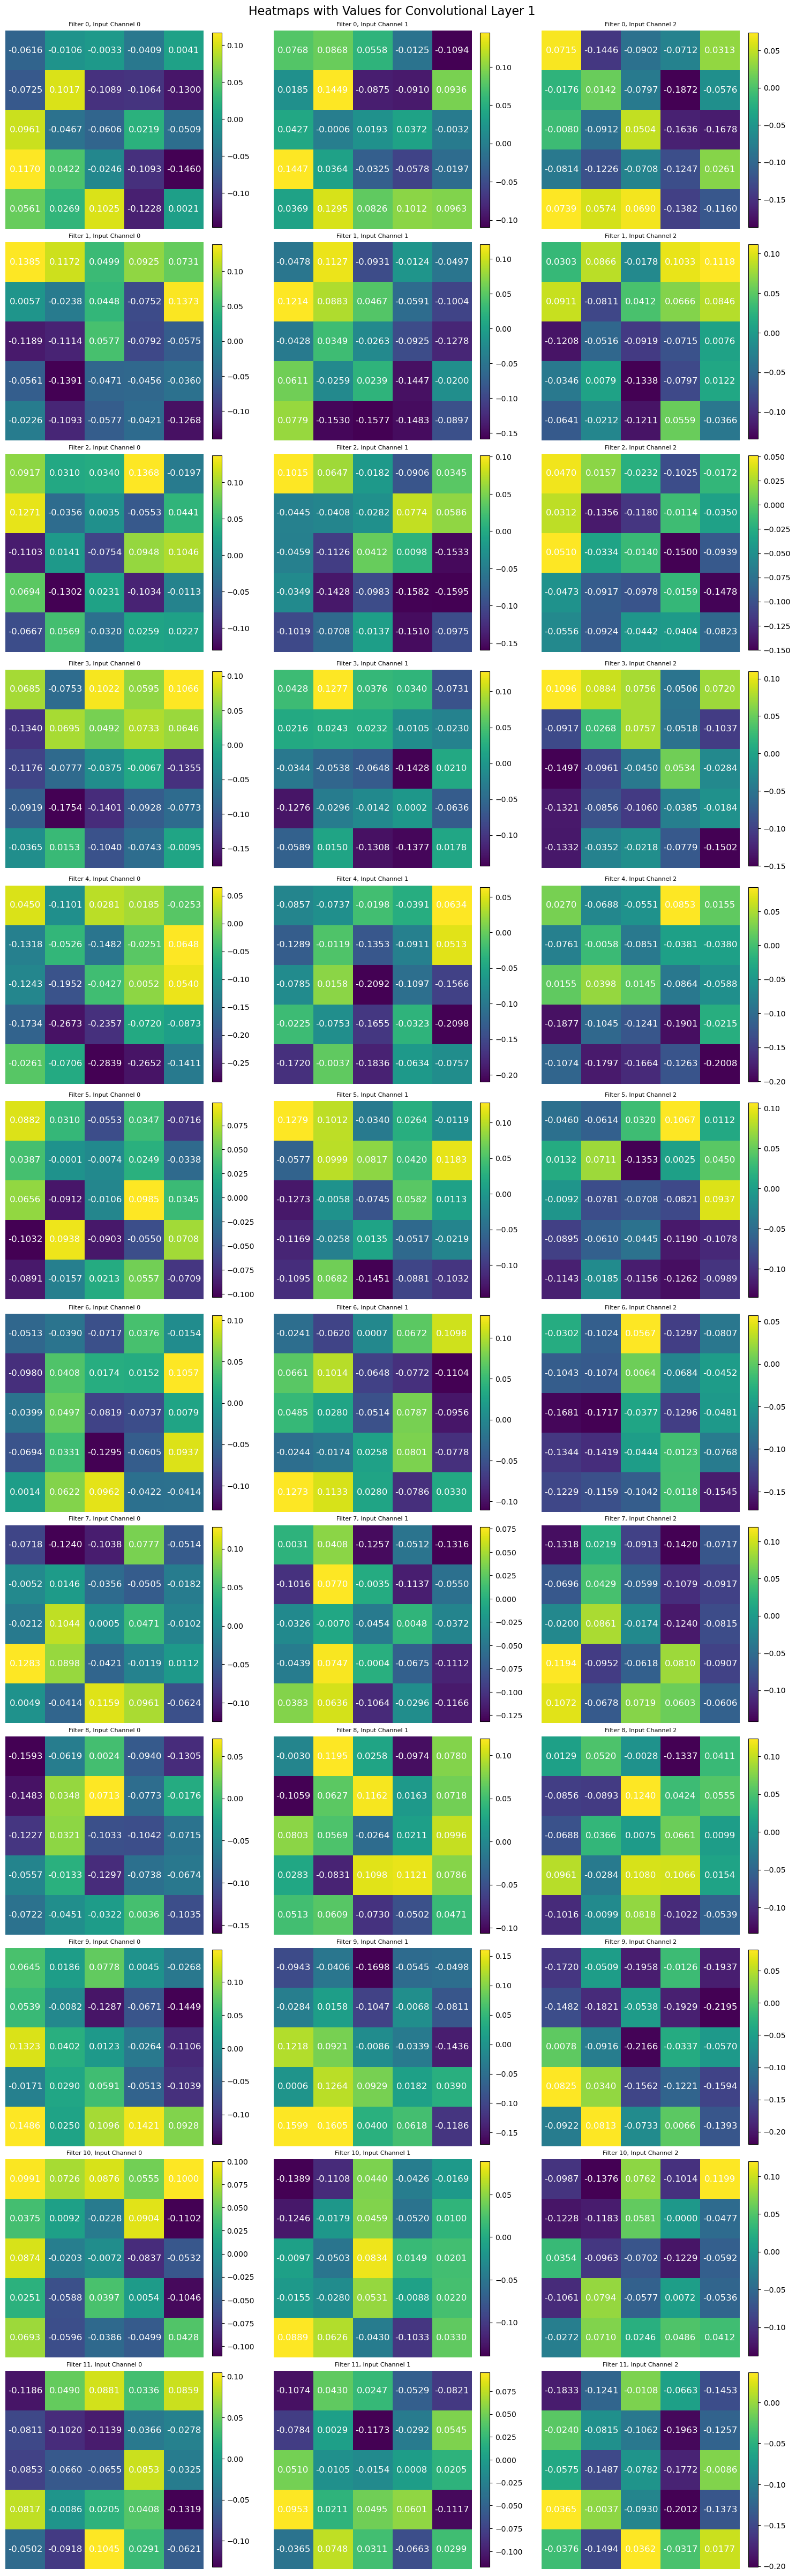

In [329]:
plot_conv1_layer_heatmaps(safety_model)

## Analysis of Convolutional Layer 1 Weights

### Key Observations
1. **Diversity Across Filters and Channels**:
    - The weights across the 12 filters in the first convolutional layer show significant variability, indicating that the model is learning diverse spatial patterns from the input images.
    - Example:
        - **Filter 0, Input Channel 0** shows a mixture of positive and negative values (e.g., `-0.0616`, `0.1169`, `0.0561`), which suggests sensitivity to both bright and dark patterns in the RGB channel.
        - **Filter 5, Input Channel 2** demonstrates weaker variations with values mostly centered around zero (e.g., `-0.0460`, `0.0320`, `0.0112`), possibly indicating lower reliance on specific features in this filter.

2. **Filter Specialization**:
    - Some filters appear to focus on more pronounced patterns or gradients, as evidenced by the range of weights.
        - Example:
            - **Filter 1, Input Channel 0** has weights ranging from `-0.1391` to `0.1372`, implying its potential role in edge or gradient detection.
            - Conversely, **Filter 2, Input Channel 1** has a narrower range, with weights between `-0.1533` and `0.0774`, suggesting a focus on subtler patterns.

3. **Symmetry in Weight Distribution**:
    - The weights in filters like **Filter 4, Input Channel 0** are distributed with near symmetry around zero, such as `[-0.1101, -0.0526, -0.0251, 0.0648]`. This symmetry often correlates with features detecting uniform patterns like textures or gradients.

4. **Learning Variance Across Channels**:
    - Weights in the second and third input channels (e.g., **Filter 3, Input Channel 1**) show varying intensities compared to the first channel. This demonstrates the model's adaptation to RGB data and its ability to differentiate between channels.

5. **Potential Over-Sensitivity**:
    - Some filters, such as **Filter 10, Input Channel 2**, have highly negative values like `-0.1833`, `-0.1962`, and `-0.1772`. These might indicate over-sensitivity to certain patterns and could potentially lead to instability during inference.

### Insights for Improvement
1. **Regularization Techniques**:
    - Given the strong negative weights in certain filters, adding weight regularization (e.g., L2 regularization) might help balance learning and avoid over-sensitivity to specific features.

2. **Weight Initialization**:
    - The variability among filters suggests the model is learning, but re-evaluating initialization strategies (e.g., Xavier or He initialization) could ensure better convergence.

3. **Feature Visualization**:
    - Filters with extreme weight values (e.g., Filter 11, Input Channel 2) should be visualized to confirm they are detecting meaningful patterns and not just noise.

### Supporting Evidence
- **Range of Weights**:
    - Filter 1, Input Channel 0: `-0.1391` to `0.1372`
    - Filter 10, Input Channel 2: `-0.1962` to `0.1198`
- **Symmetry**:
    - Filter 4, Input Channel 0: Weights are symmetric around zero, e.g., `[-0.1101, -0.0526, -0.0251, 0.0648]`.

These observations demonstrate the diversity of learned spatial features in the first convolutional layer, reflecting the model's capability to extract meaningful patterns.

### Convolutional Layer 2 Heatmaps

In [332]:
def plot_conv2_layer_heatmaps_limited(model):
    # Extract the second convolutional layer weights
    weights = model.conv2.weight.data.cpu().numpy()  # Get the weight tensor and convert to numpy
    num_filters, num_input_channels, _, _ = weights.shape  # Get the shape of the weights

    # Limit to the first 2 output channels
    num_output_channels_to_plot = 2
    num_heatmaps_per_row = 4

    fig, axes = plt.subplots(
        num_output_channels_to_plot * num_input_channels // num_heatmaps_per_row, num_heatmaps_per_row,
        figsize=(15, (num_output_channels_to_plot * num_input_channels // num_heatmaps_per_row) * 3),
        constrained_layout=True
    )

    axes = axes.flatten()

    for idx, (out_channel, in_channel) in enumerate(
        [(out, inp) for out in range(num_output_channels_to_plot) for inp in range(num_input_channels)]
    ):
        heatmap_data = weights[out_channel, in_channel]
        ax = axes[idx]
        im = ax.imshow(heatmap_data, cmap='viridis')
        ax.set_title(f"Filter {out_channel}, Input Channel {in_channel}", fontsize=8)
        
        # Annotate the heatmap with the numerical values
        for x in range(heatmap_data.shape[0]):
            for y in range(heatmap_data.shape[1]):
                ax.text(y, x, f"{heatmap_data[x, y]:.4f}", ha="center", va="center", fontsize=8, color="white")
        
        ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Turn off any unused axes
    for idx in range(len(axes)):
        if idx >= num_output_channels_to_plot * num_input_channels:
            axes[idx].axis('off')

    plt.suptitle("Heatmaps for Convolutional Layer 2 (First 2 Output Channels, 4 per Row)", fontsize=16)
    plt.show()

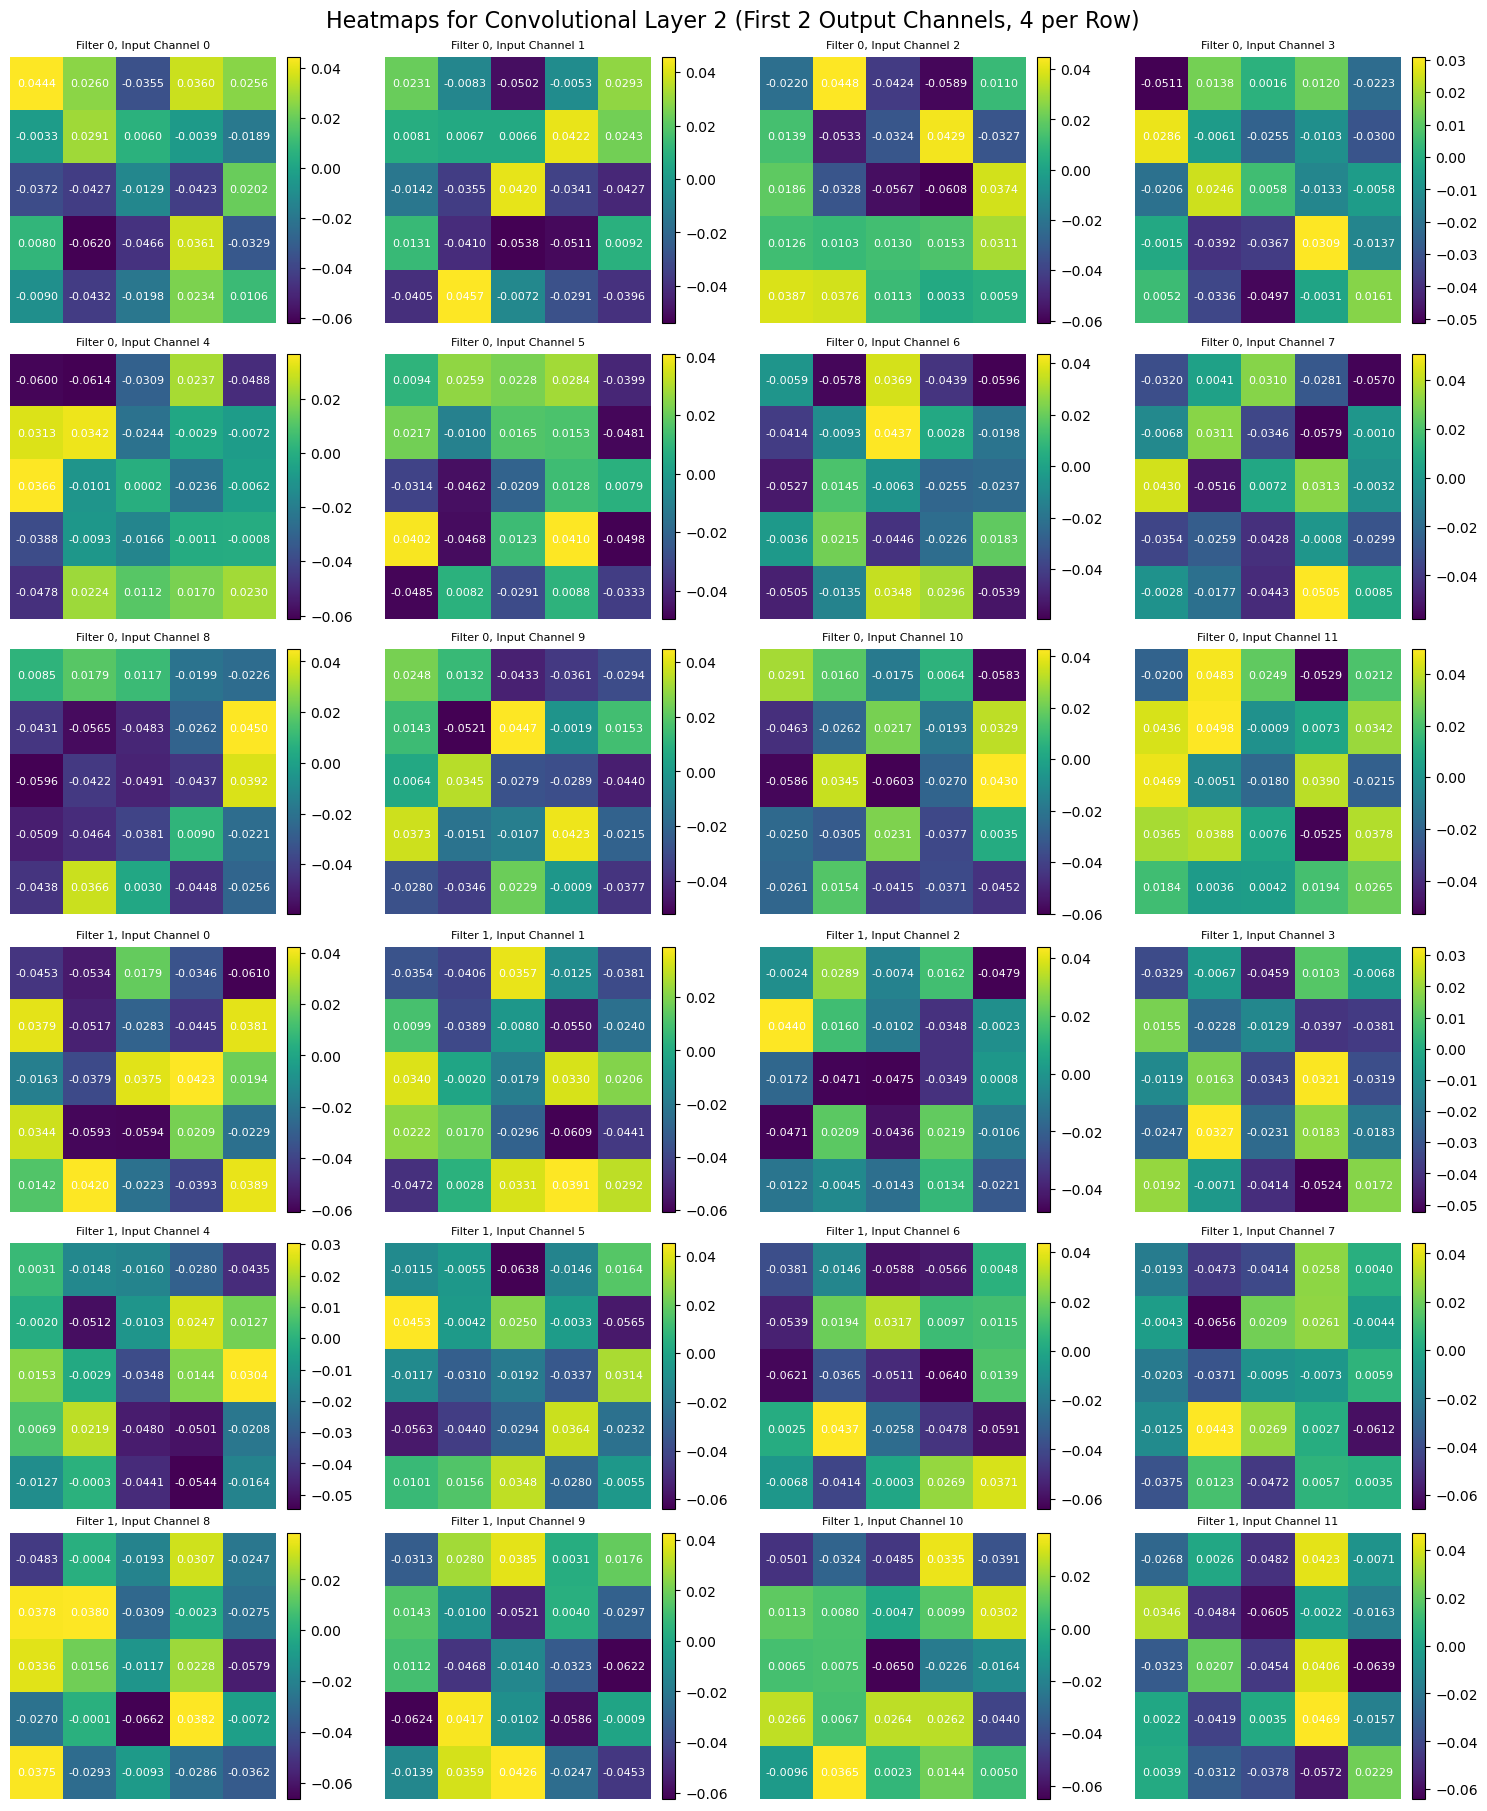

In [333]:
plot_conv2_layer_heatmaps_limited(safety_model)

## Insights from Convolutional Layer 2 Weights (Filters 0 and 1)

### Key Observations
1. **Wide Range of Values Across Channels**:
   - Filter 0, Input Channel 2: Values range from `-0.0608` to `0.0448`, indicating sensitivity to both positive and negative features in this channel.
   - Filter 1, Input Channel 6: Strong negative values dominate, such as `-0.0621` and `-0.0640`, suggesting a focus on detecting dark or low-intensity regions.

2. **Specialization in Feature Extraction**:
   - Filter 0, Input Channel 3: Symmetrical weight distribution (e.g., `-0.0511`, `0.0120`, `0.0161`) may contribute to detecting uniform patterns or textures.
   - Filter 1, Input Channel 0: Strong variations (`-0.0610` to `0.0423`) imply the ability to capture edges and gradients effectively.

3. **Potential Over-Sensitivity**:
   - Filter 1, Input Channel 11: Extreme negative values like `-0.0605` and `-0.0639` might indicate an over-sensitivity to specific patterns, which could require further regularization.

### Supporting Evidence
- **Filter 0, Input Channel 2**: Values range from `-0.0608` to `0.0448`.
- **Filter 1, Input Channel 0**: Values range from `-0.0610` to `0.0423`.
- **Filter 1, Input Channel 11**: Extreme values like `-0.0605`, `-0.0639`.

These insights highlight how the second convolutional layer focuses on diverse patterns, with some channels emphasizing edges and gradients while others exhibit strong negative weights potentially requiring regularization.


# Other Helper Functions

Since the data from Kaggle was already split into `train`, `val`, `test`. I wanted to consolidate all of them. To avoid duplicate names, I renamed some of the image files using the function below.

In [252]:
def rename_images(folder_path, start_number):
    """
    Renames all image files in the given folder based on a starting number.
    
    Parameters:
    folder_path (str): The path to the folder containing the image files to rename.
    start_number (int): The starting number for renaming the image files.
    
    The files will be renamed sequentially from the starting number, with the format "<start_number>.jpg", "<start_number + 1>.jpg", etc.
    """
    # List all files in the folder
    files = os.listdir(folder_path)
    
    # Sort files to maintain consistent renaming order
    files.sort()
    
    # Iterate over all files and rename them based on the given number
    for idx, filename in enumerate(files):
        # Construct new file name with the given number and its index
        new_name = f"{start_number + idx}.jpg"
        
        # Create full paths for the old and new file names
        old_path = os.path.join(folder_path, filename)
        new_path = os.path.join(folder_path, new_name)
        
        # Rename the file
        os.rename(old_path, new_path)

# Tutorials

[Image Classification CNN in PyTorch](https://www.youtube.com/watch?v=CtzfbUwrYGI)